In [2]:
#Common Python Packages
from pickle import TRUE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import timeout_decorator

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product

#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio



The first index loop is the neuron  utilized
dict_keys([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95])
The second index is the leakage fine value utilized
dict_keys([40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88])


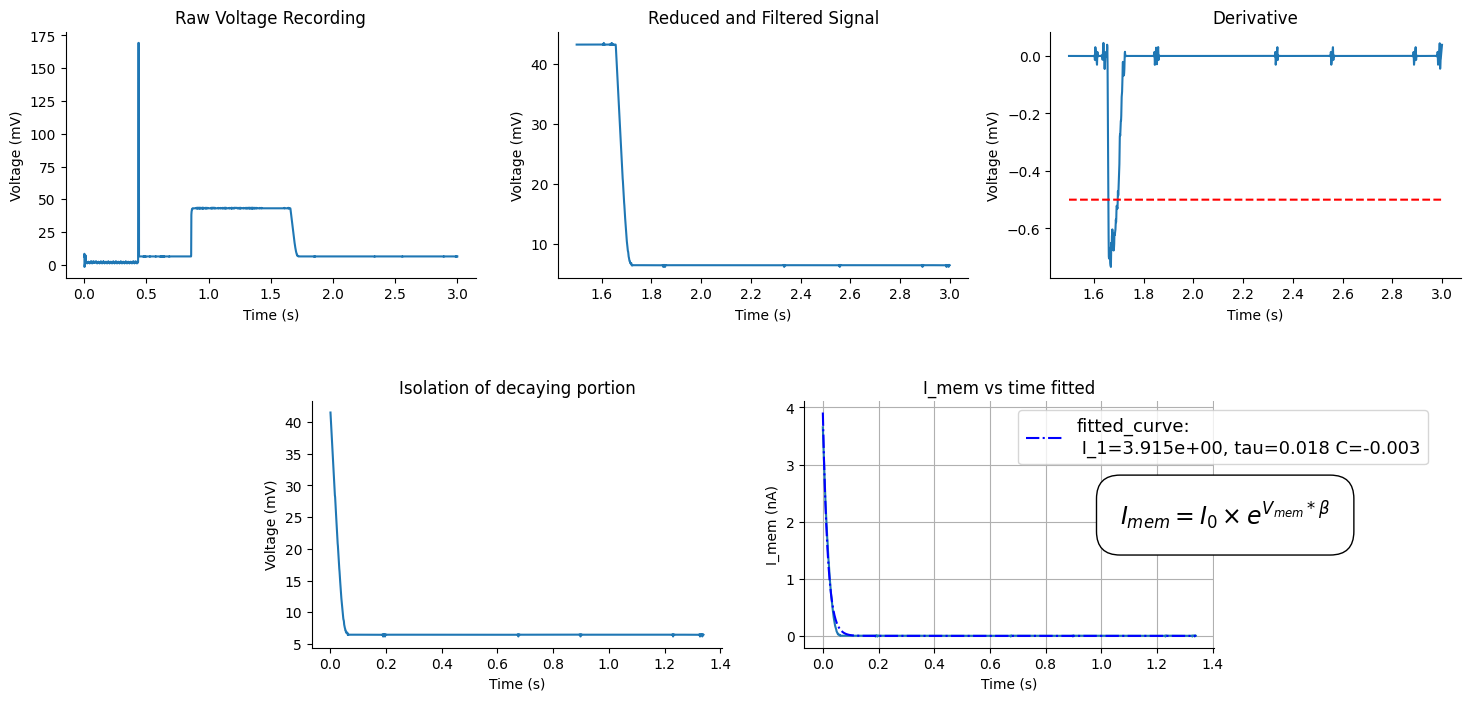

In [35]:

# Data structures
recordings_neuron_core_0_coarse_0 = np.load(
    'pulse_data_core_0_coarse_0.npy', allow_pickle=True).item()
recordings_neuron_core_0_coarse_1 = np.load(
    'pulse_data_core_0_coarse_1.npy', allow_pickle=True).item()
recordings_nueron_core_1_coarse_1 = np.load(
    'pulse_data_core_1_coarse_1.npy', allow_pickle=True).item()
recordings_neuron_core_2_coarse_1 = np.load(
    'pulse_data_core_2_coarse_1.npy', allow_pickle=True).item()
# Access the data for the first key of the outer dictionary
print('The first index loop is the neuron  utilized')
print(recordings_neuron_core_0_coarse_1.keys())
print('The second index is the leakage fine value utilized')
print(recordings_neuron_core_0_coarse_1[0].keys())
#first index is the neuron index, second index is the leakage fine value
tc_extraction.time_constant_extraction(recordings_neuron_core_2_coarse_1[0][40], output='analysis', beta=1/26, cut_off=500, window_length=11, polyorder=3)


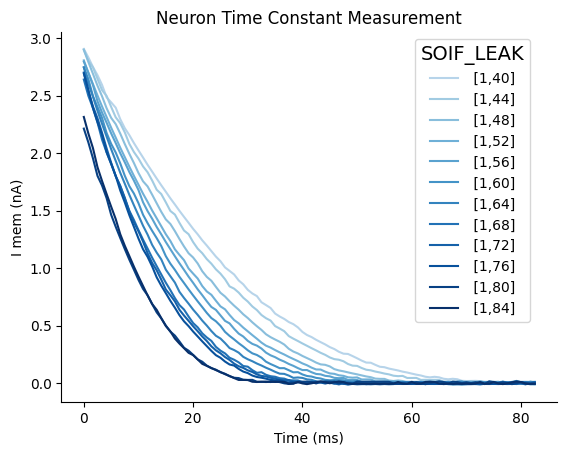

25
25
25
25
25
25


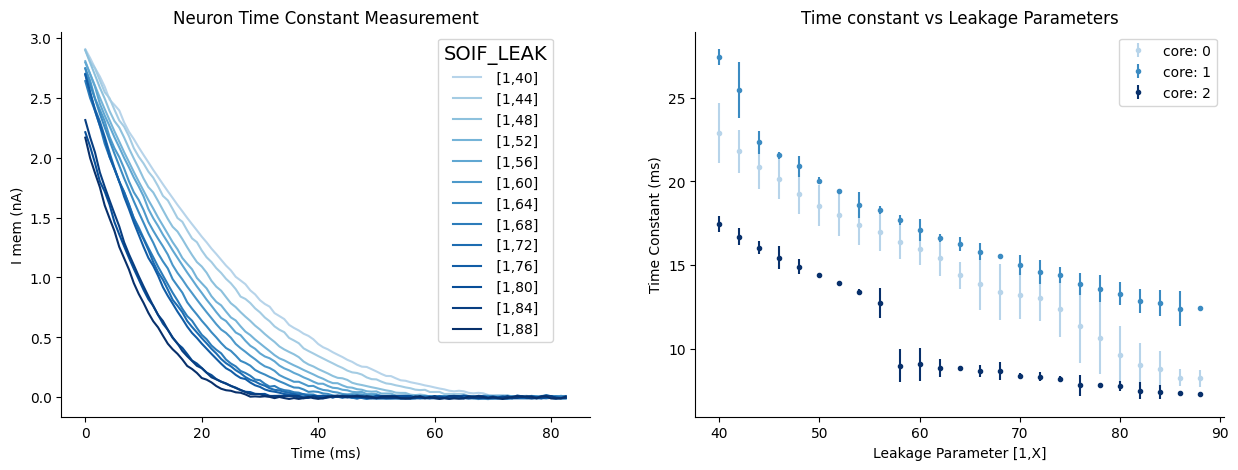

In [65]:



neurons=np.arange(0,95,5)
leak_range=np.arange(40,90,4)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define a color map to generate colors for your lines
colors = cm.Blues(np.linspace(0.3, 1, len(leak_range)))
#plot in the first axes 
nueron=10
color_counter=0
for j in leak_range:
    [x,y]=tc_extraction.time_constant_extraction(recordings_neuron_core_0_coarse_1[10][j],  output='curve', beta=1/26, cut_off=500, window_length=11, polyorder=3)
    ax1.plot(y[0:100]*1000,x[0:100], label=' [1,'+str(j)+']',color=colors[color_counter])
    color_counter=color_counter+1

# Create the legend box, and give it a title
legend = ax1.legend(bbox_to_anchor=(.7, 1), loc='upper left', fontsize=10, title="SOIF_LEAK")
plt.setp(legend.get_title(),fontsize=14)  # Setting legend title font size

ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('I mem (nA)')
ax1.set_title('Neuron Time Constant Measurement')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

leak_range=np.arange(40,90,2)
coarse_value=1

for i in range(3):
    time_constant_data_path = f'pulse_tc_data_core_{i}_coarse_1_n.npz'
    data = np.load(time_constant_data_path, allow_pickle=True)
    time_constant_data_matrix = data['time_constant_data_matrix']
    mean_time_constants = data['mean_time_constants']
    std_time_constants = data['std_time_constants']

    ax2.set_xlabel(f'Leakage Parameter [{coarse_value},X]')
    ax2.set_ylabel('Time Constant (ms)')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_title('Time constant vs Leakage Parameters')
    print(len(leak_range))
    print(len(mean_time_constants))
    # plot mean time constants with error bars representing standard deviation
    ax2.errorbar(leak_range, mean_time_constants, yerr=std_time_constants, fmt='.', label=f'core: {i}', color=colors[i*6])

    #save plot as svg
    #fig.savefig(f'time_constant_vs_leakage_core_{core}_coarse_{coarse_value}.svg', format='svg')
plt.legend()
plt.show()

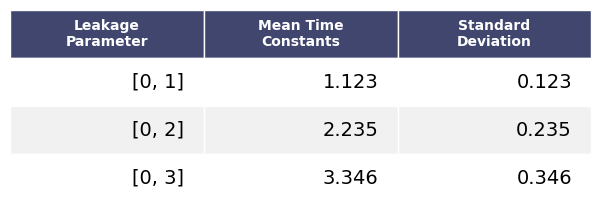

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import six
import numpy as np

data_dict = {
    'Leakage Parameter': [1, 2, 3],
    'Mean Time Constants': [1.123456, 2.234567, 3.345678],
    'Standard Deviation': [0.123456, 0.234567, 0.345678]
}

df = pd.DataFrame(data_dict)

# Round to 3 decimal places
df['Mean Time Constants'] = df['Mean Time Constants'].round(3)
df['Standard Deviation'] = df['Standard Deviation'].round(3)

# Format Leakage Parameter
df['Leakage Parameter'] = df['Leakage Parameter'].apply(lambda x: f'[0, {x}]')

# Rename columns with line breaks for text wrapping
df.columns = ['Leakage\nParameter',
              'Mean Time\nConstants', 'Standard\nDeviation']


def render_mpl_table(data, col_width=3.5, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])
                ) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox,
                         colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            # smaller font for headers
            cell.set_text_props(weight='bold', color='w', size=10)
            cell.set_facecolor(header_color)
            cell._text.set_wrap(True)  # Enable text wrapping for headers
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
    return ax.get_figure(), ax


fig, ax = render_mpl_table(df, header_columns=0, col_width=2.5)
fig.savefig("table.png")
